In [8]:
#Necessary imports

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import pandas as pd
import dlib


from scipy.signal import butter, filtfilt, lfilter
from scipy.fft import fft, fftfreq
from datetime import datetime

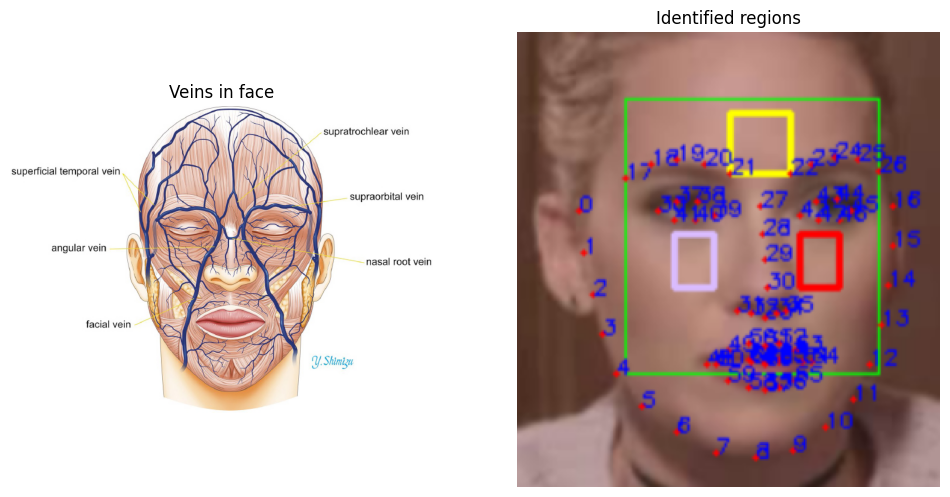

In [9]:

# Define image paths
image_path1 = 'images/veins_position.jpg'  # Replace with your first image path
image_path2 = 'images/landmarks.png'  # Replace with your second image path

# Check if the image files exist
if not os.path.isfile(image_path1):
    print("Error: The first image file does not exist.")
if not os.path.isfile(image_path2):
    print("Error: The second image file does not exist.")

# Load images using OpenCV
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)

# Check if the images are loaded successfully
if image1 is None or image2 is None:
    print("Error: Could not load one or both images.")
else:
    # Convert the images from BGR to RGB format
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Create a figure with 1 row and 2 columns of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the first image in the first subplot
    axes[0].imshow(image1_rgb)
    axes[0].axis('off')  # Hide the axes
    axes[0].set_title('Veins in face')

    # Display the second image in the second subplot
    axes[1].imshow(image2_rgb)
    axes[1].axis('off')  # Hide the axes
    axes[1].set_title('Identified regions')

    # Display the figure
    plt.show()


In [10]:
#Constants
low_cutoff = 0.75
high_cutoff = 2.5
fps=0
fs = 2 * high_cutoff

#Paths
dlib_path = 'dlib_files/shape_predictor_68_face_landmarks.dat'
video_path = 'videos/fake/jennyf.mp4'

#pulses values
pulses_forehead=[]
pulses_leftc=[]
pulses_rightc=[]
pulses_fullf=[]

#creating folder in plots to save current plots

folder_path = "plots/"+ video_path.split('/')[-1].split('.')[0] + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
try:
    os.mkdir(folder_path)
    print(folder_path)
except FileExistsError:
    print("Folder already exists!")

plots/jennyf_2024_06_19_15_06_42


In [11]:
#Utility functions

def calculate_pulse_signal(roi,pulses):
    
    B, G, R = cv2.split(roi)
    
    #Normalizing R,G,B channels
    
    Rn = R / np.mean(R)
    Gn = G / np.mean(G)
    Bn = B / np.mean(B)    
    
    #CHROM Signals
    
    Xs = 3*Rn - 2*Gn
    Ys = 1.5*Rn + Gn - 1.5*Bn
    
    Rf = apply_bandpass_filter(Rn)
    Gf = apply_bandpass_filter(Gn)
    Bf = apply_bandpass_filter(Bn)
    Xf = apply_bandpass_filter(Xs)
    Yf = apply_bandpass_filter(Ys)

    alpha = np.std(Xf) / np.std(Yf)

    Signal = 3*(1-(alpha/2))*Rf - 2*(1 + (alpha/2))*Gf + ((3*alpha)/2)*Bf
    
    pulses.append(np.mean(Signal))  

def apply_bandpass_filter(channel, order=5):
    b, a = butter_bandpass(order)
    y = filtfilt(b, a, channel, axis=0,padlen=0)
    return y

def butter_bandpass(order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    lowcut_norm = low_cutoff / nyquist 
    highcut_norm = high_cutoff / nyquist
    # print(lowcut,highcut,lowcut_norm,highcut_norm)
    b, a = butter(order, [lowcut_norm, highcut_norm-0.1], btype='band')
    return b, a


def heartrate_detected(signal):
    # Collapse 3D signal array to 1D time series by averaging over spatial dimensions
    time_series = signal

    # Apply FFT
    N = len(time_series)
    yf = fft(time_series)
    xf = fftfreq(N, 1 / fps)[:N // 2]

    # Find the dominant frequency in the expected heart rate range
    heart_rate_range = (low_cutoff, high_cutoff)
    idx_range = np.where((xf >= heart_rate_range[0]) & (xf <= heart_rate_range[1]))
    dominant_freq = xf[idx_range][np.argmax(np.abs(yf[idx_range]))]

    # Convert frequency to beats per minute (BPM)
    bpm = dominant_freq * 60

    return bpm


def signal_plotting(signal, region_name, color):
    time_series = signal
    bpm = heartrate_detected(signal)
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label=f'{region_name} Pulse Signal', color=color)
    plt.title(f'{region_name} Pulse Signal over Time')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.text(0.05, 0.95, f'Estimated Heart Rate: {bpm:.2f} BPM', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.savefig(f'{folder_path}/{region_name}_pulse_signal.png')
    plt.clf()
    
    

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

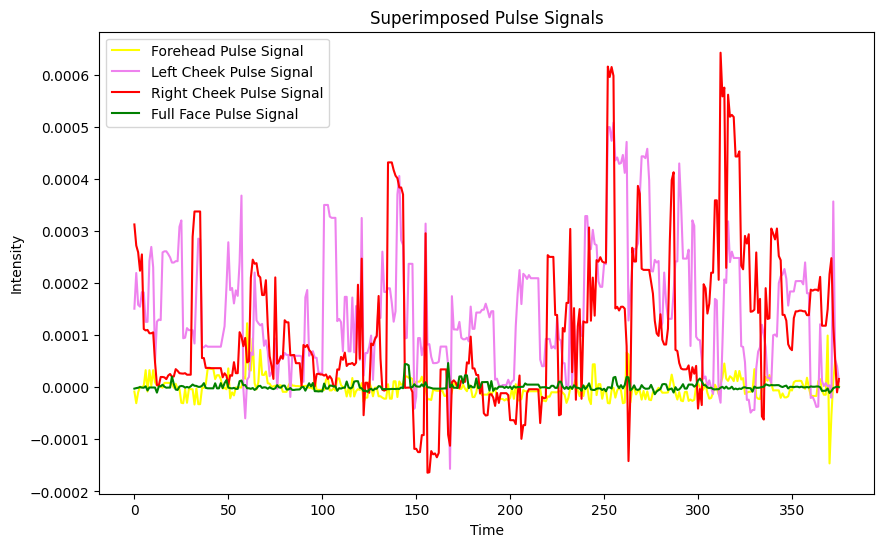

In [12]:


# Load face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(dlib_path)

# Open video file
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))


# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = detector(gray)
    
    if(len(faces) > 1):
        break

    # Process each detected face
    for face in faces:
        # Detect facial landmarks
        landmarks = predictor(gray, face)
        
        # Identify forehead region based on landmarks
        forehead_r1=[0,0,0,0] #x1,x2,y1,y2
        
        forehead_r1[0] = landmarks.part(21).x # Left eyebrow-x
        forehead_r1[1] = landmarks.part(22).x  # Right eyebrow-x
        forehead_r1_height=int((forehead_r1[1] - forehead_r1[0]))
        forehead_r1[2] = landmarks.part(21).y - forehead_r1_height # Left eyebrow-y
        forehead_r1[3] = landmarks.part(22).y # Right eyebrow-y       
        
        
        

        # Identify left cheek region-1 based on landmarks
        leftc_r1=[0,0,0,0] #x1,x2,y1,y2
        
        leftc_r1[0]=landmarks.part(41).x
        leftc_r1[1]=landmarks.part(39).x
        leftc_r1[2]=landmarks.part(28).y
        leftc_r1[3]=landmarks.part(30).y

        # Identify right cheek region-1 based on landmarks
        rightc_r1=[0,0,0,0] #x1,x2,y1,y2
        
        rightc_r1[0]=landmarks.part(42).x
        rightc_r1[1]=landmarks.part(46).x
        rightc_r1[2]=landmarks.part(28).y
        rightc_r1[3]=landmarks.part(30).y

        # Identify right cheek region-1 based on landmarks
        fullf=[0,0,0,0] #x1,x2,y1,y2
        
        fullf[0]=landmarks.part(17).x
        fullf[1]=landmarks.part(26).x
        fullf[2]=landmarks.part(19).y - forehead_r1_height
        fullf[3]=landmarks.part(4).y      

        #Calculating pulse signals values for roi's
        
        calculate_pulse_signal(frame[forehead_r1[2]:forehead_r1[3],forehead_r1[0]:forehead_r1[1]],pulses_forehead)
        calculate_pulse_signal(frame[leftc_r1[2]:leftc_r1[3],leftc_r1[0]:leftc_r1[1]],pulses_leftc)
        calculate_pulse_signal(frame[rightc_r1[2]:rightc_r1[3],rightc_r1[0]:rightc_r1[1]],pulses_rightc)
        calculate_pulse_signal(frame[fullf[2]:fullf[3],fullf[0]:fullf[1]],pulses_fullf)


         # Draw rectangle with increased breadth
        cv2.rectangle(frame, (forehead_r1[0], forehead_r1[2]), (forehead_r1[1], forehead_r1[3]), (0,255,255), 2)
        cv2.rectangle(frame, (leftc_r1[0], leftc_r1[2]), (leftc_r1[1], leftc_r1[3]), (255,188,218), 2)
        cv2.rectangle(frame, (rightc_r1[0], rightc_r1[2]), (rightc_r1[1], rightc_r1[3]), (0, 0, 255), 2)
        cv2.rectangle(frame, (fullf[0], fullf[2]),(fullf[1], fullf[3]), (0, 255, 0), 1)
        # Draw facial landmarks with numbers
        for i in range(0, 68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
        

    # Display frame with highlighted forehead region and facial landmarks
    cv2.imshow('Face Regions Detection using Landmarks', frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()

signal_plotting(pulses_forehead,'fore head', 'yellow')
signal_plotting(pulses_leftc,'left cheek', 'violet')
signal_plotting(pulses_rightc,'right cheek', 'red')
signal_plotting(pulses_fullf,'full face', 'green')

#Superimposed pulse signals plot

plt.figure(figsize=(10, 6))
plt.plot(pulses_forehead, label='Forehead Pulse Signal',color='yellow')
plt.plot(pulses_leftc, label='Left Cheek Pulse Signal',color='violet')
plt.plot(pulses_rightc, label='Right Cheek Pulse Signal',color='red')
plt.plot(pulses_fullf, label='Full Face Pulse Signal',color='green')
plt.title('Superimposed Pulse Signals')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.savefig(folder_path +'/superimposed_pulse_signals.png')


In [13]:
#saving the pulse values in excel sheet
workbook = openpyxl.Workbook()
worksheet = workbook.active
worksheet.title = "Pulse Signals"

# Define column headers
column_headers = ["Forehead", "Left Cheek", "Right Cheek", "Full Face"]
worksheet.append(column_headers)

# Write pulse signal data to rows
data_length = len(pulses_forehead)
for i in range(data_length):
  worksheet.cell(row=i+2, column=1).value = pulses_forehead[i]
  worksheet.cell(row=i+2, column=2).value = pulses_leftc[i]
  worksheet.cell(row=i+2, column=3).value = pulses_rightc[i]
  worksheet.cell(row=i+2, column=4).value = pulses_fullf[i]

workbook.save(f"{folder_path}/pulse_signals.xlsx")

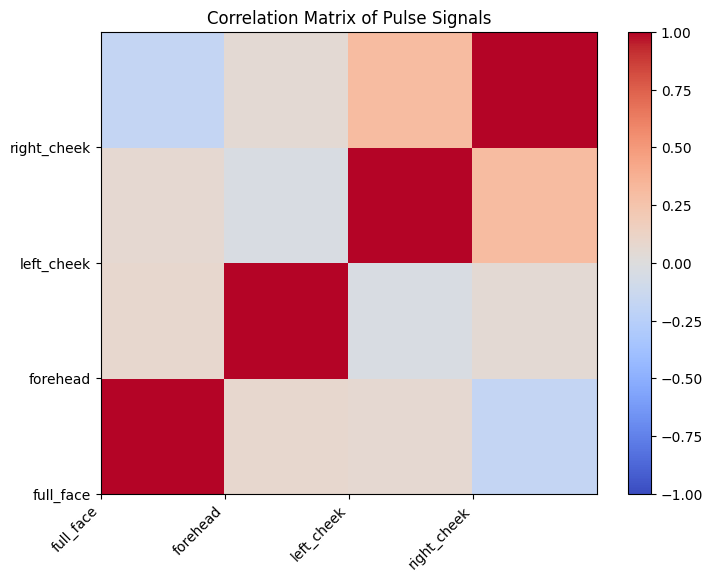

In [14]:
#Computing Correlation matrix on pulse signals
data = {'full_face': pulses_fullf, 'forehead': pulses_forehead, 'left_cheek': pulses_leftc, 'right_cheek': pulses_rightc}

df = pd.DataFrame(data)

correlation_matrix = df.corr()

#plotting the correlation matrix

plt.figure(figsize=(8, 6))
heatmap = plt.pcolor(correlation_matrix, vmin=-1, vmax=1, cmap='coolwarm') 
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar(heatmap)
plt.title('Correlation Matrix of Pulse Signals')
plt.savefig(f'{folder_path}/correlation_matrix.png', bbox_inches='tight', pad_inches=0.0)
plt.show()